Здравствуйте, уважаемый читатель! \
Здесь представлено мое решение тестового задания по декодированию аудиосигналов, закодированного азбукой Морзе. Спасибо, что уделяете мне время, приятного изучения! :)

# **Предобработка данных.**

## **Анализ данных.**

Как и в любой задаче машинного обучения - все началось с изучения самих данных. Прочитав логи, я прислушался к колонии и решил использовать mel-спектрограммы. Покопавшись в интернете, также пришел к выводу о том, что для декодирования азбуки морзе это хороший вариант. Но как выбрать подходящие параметры? Я решил вывести основные характеристики аудио, чтобы это выяснить.

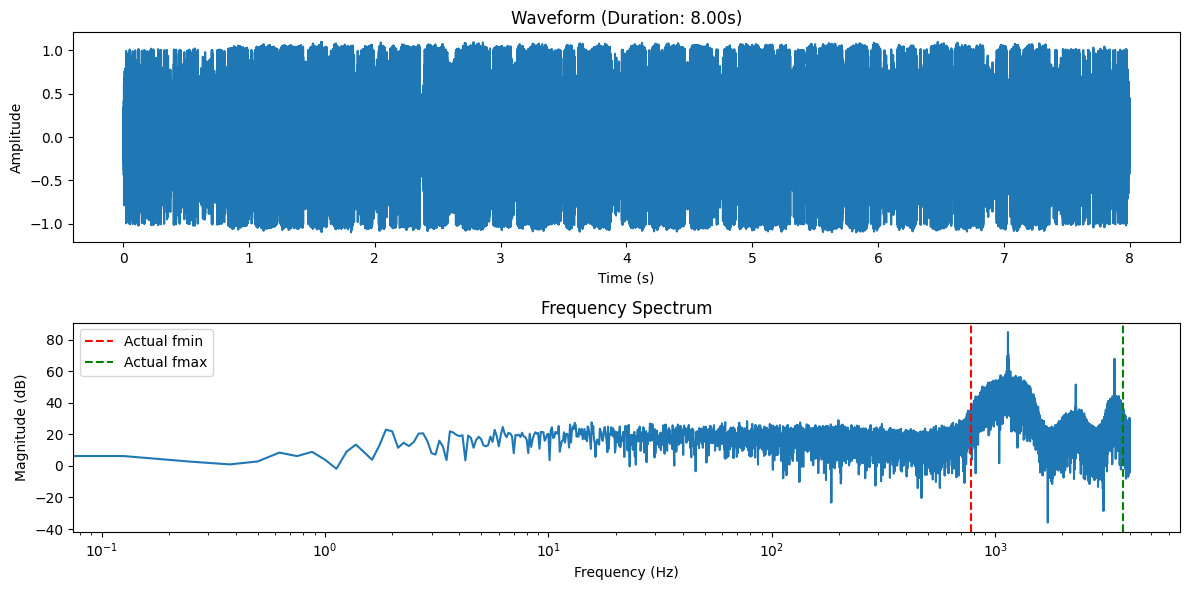

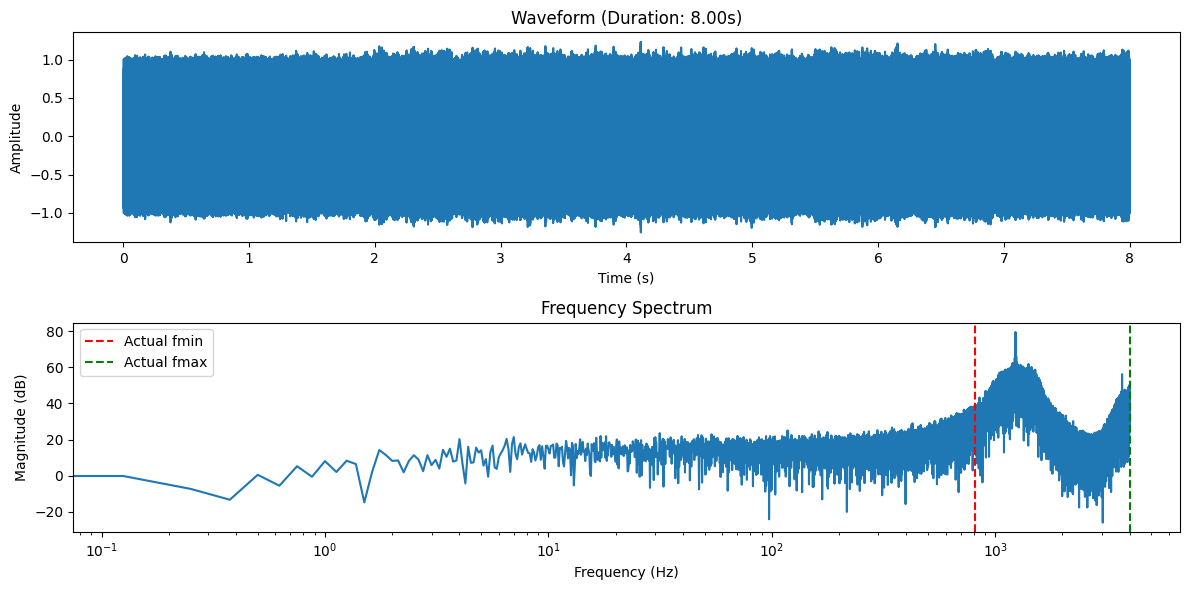

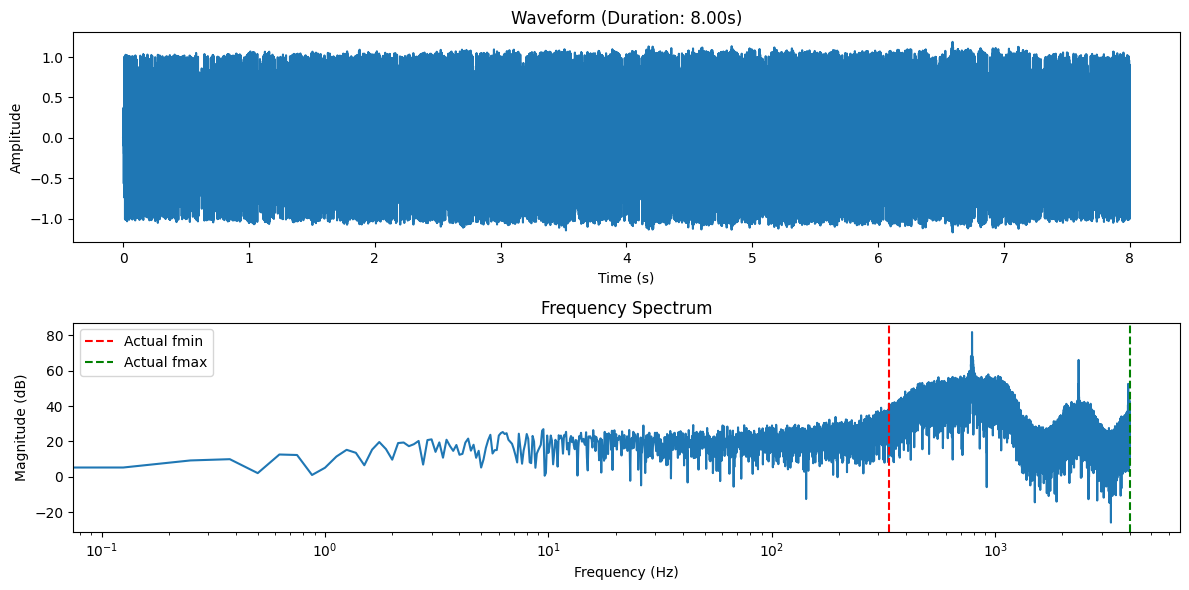

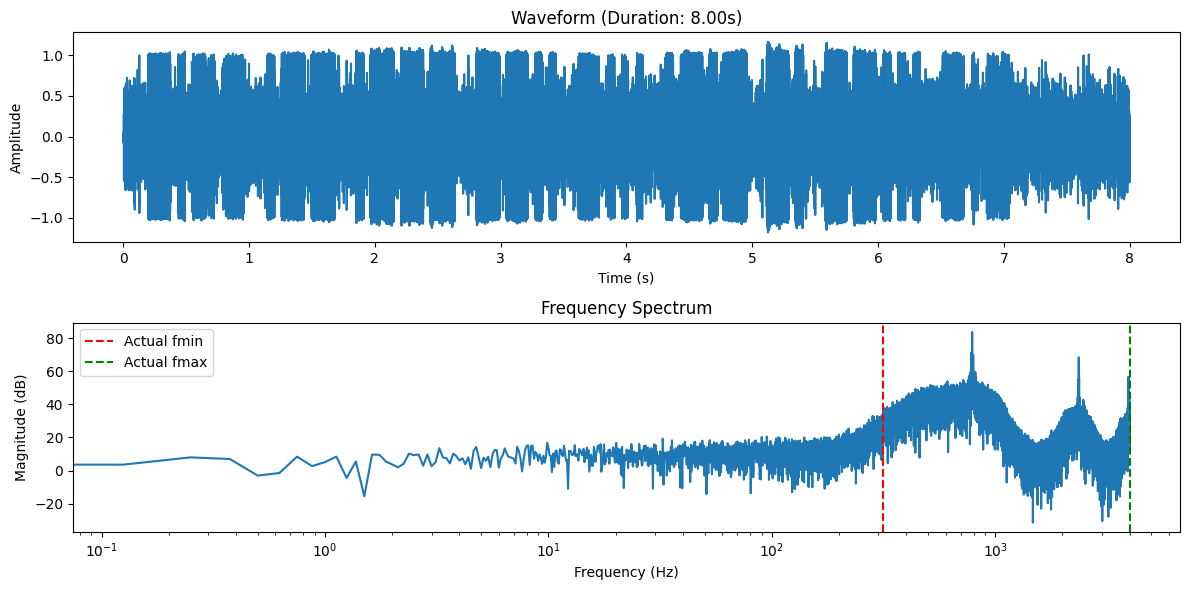

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def analyze_audio(file_path, auto_plot=False, target_sr=8000):
    """
    Анализирует аудиофайл и рекомендует параметры для Mel-спектрограмм.

    Параметры:
        file_path (str): Путь к аудиофайлу
        auto_plot (bool): Автоматически строить графики (по умолчанию True)
        target_sr (int): Желаемая частота дискретизации (None для исходной)

    Возвращает:
        dict: Словарь с рекомендованными параметрами и метриками
    """
    # Загрузка аудио с исходной или целевой частотой дискретизации
    y, sr = librosa.load(file_path, sr=target_sr)

    # Основные метрики
    duration = len(y) / sr
    energy = np.sum(y**2) / len(y)  # Средняя энергия сигнала

    # Спектральный анализ
    fft = np.fft.rfft(y)
    frequencies = np.fft.rfftfreq(len(y), d=1/sr)
    magnitudes = np.abs(fft)

    # Находим значимые частоты (игнорируем тихие части)
    noise_floor = np.percentile(magnitudes, 50)  # Порог как медианная амплитуда
    significant = magnitudes > noise_floor * 5    # 5x выше шума

    # Основные частотные характеристики
    main_freq = frequencies[np.argmax(magnitudes)]
    fmin_actual = frequencies[significant].min()
    fmax_actual = frequencies[significant].max()

    # Рекомендуемые параметры
    params = {
        'sample_rate': sr,
        'duration': duration,
        'energy': energy,
        'main_frequency': main_freq,
        'fmin_actual': fmin_actual,
        'fmax_actual': fmax_actual,
        'recommended': {
            'n_fft': 2**int(np.log2(0.025 * sr)),  # 25 мс окно
            'hop_length': None,  # Рассчитаем ниже
            'n_mels': 64 if duration > 1.0 else 32,  # Для длинных записей больше полос
            'fmin': max(50, int(fmin_actual * 0.8)),  # 20% запас снизу
            'fmax': min(sr//2, int(fmax_actual * 1.2)), # 20% запас сверху
            'max_length': int(duration * sr / (0.025 * sr * 0.5))  # В кадрах
        }
    }

    # Рассчет hop_length (50% от n_fft по умолчанию)
    params['recommended']['hop_length'] = params['recommended']['n_fft'] // 2

    # Визуализация
    if auto_plot:
        plt.figure(figsize=(12, 6))

        # Исходный сигнал
        plt.subplot(2, 1, 1)
        plt.plot(np.linspace(0, duration, len(y)), y)
        plt.title(f"Waveform (Duration: {duration:.2f}s)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # Частотный спектр
        plt.subplot(2, 1, 2)
        plt.semilogx(frequencies, 20 * np.log10(magnitudes + 1e-10))
        plt.axvline(fmin_actual, color='r', linestyle='--', label='Actual fmin')
        plt.axvline(fmax_actual, color='g', linestyle='--', label='Actual fmax')
        plt.title("Frequency Spectrum")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude (dB)")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return params

directory = "/kaggle/input/decoder/morse_dataset/morse_dataset/"
all_params = {'sample_rate': [],
        'duration': [],
        'energy': [],
        'main_frequency': [],
        'fmin_actual': [],
        'fmax_actual': [],
        'recommended': {
            'n_fft': [],
            'hop_length': [],
            'n_mels': [],
            'fmin': [],
            'fmax': [],
            'max_length': []
        }}

for file_num in range(1, 35001):
    if file_num == 30001:
        all_params_train = all_params
        all_params = {'sample_rate': [],
        'duration': [],
        'energy': [],
        'main_frequency': [],
        'fmin_actual': [],
        'fmax_actual': [],
        'recommended': {
            'n_fft': [],
            'hop_length': [],
            'n_mels': [],
            'fmin': [],
            'fmax': [],
            'max_length': []
        }}
    path = directory + str(file_num) + ".opus"
    params = analyze_audio(path, True if file_num % 9999 == 1 else False)
    for key in params.keys():
        if key == "recommended":
          for subkey in all_params[key].keys():
              all_params[key][subkey].append(params[key][subkey])
        else:
            all_params[key].append(params[key])
all_params_test = all_params

In [ ]:
def calculate_statistics(params_dict, name):
    print(f"\nStatistics for {name}:")

    def compute_stats(data_list):
        if not data_list:
            return None
        arr = np.array(data_list)
        return {
            'min': np.min(arr),
            'max': np.max(arr),
            'mean': np.mean(arr),
            'median': np.median(arr)
        }

    # Основные параметры
    print("\nMain parameters:")
    for key in params_dict:
        if key == 'recommended':
            continue
        values = params_dict[key]
        stats = compute_stats(values)
        if stats:
            print(f"{key}:")
            print(f"  Min: {stats['min']:.2f}")
            print(f"  Max: {stats['max']:.2f}")
            print(f"  Mean: {stats['mean']:.2f}")
            print(f"  Median: {stats['median']:.2f}\n")

    # Recommended параметры
    if 'recommended' in params_dict:
        print("\nRecommended parameters:")
        for key in params_dict['recommended']:
            values = params_dict['recommended'][key]
            stats = compute_stats(values)
            if stats:
                print(f"{key}:")
                print(f"  Min: {stats['min']:.2f}")
                print(f"  Max: {stats['max']:.2f}")
                print(f"  Mean: {stats['mean']:.2f}")
                print(f"  Median: {stats['median']:.2f}\n")

# Для тренировочных данных
calculate_statistics(all_params_train, 'train data')

# Для тестовых данных
calculate_statistics(all_params_test, 'test data')


Statistics for train data:

Main parameters:
sample_rate:
  Min: 8000.00
  Max: 8000.00
  Mean: 8000.00
  Median: 8000.00

duration:
  Min: 8.00
  Max: 8.00
  Mean: 8.00
  Median: 8.00

energy:
  Min: 0.23
  Max: 0.52
  Mean: 0.43
  Median: 0.45

main_frequency:
  Min: 400.00
  Max: 1300.00
  Mean: 850.54
  Median: 851.62

fmin_actual:
  Min: 0.25
  Max: 958.88
  Mean: 399.13
  Median: 386.38

fmax_actual:
  Min: 1484.62
  Max: 4000.00
  Mean: 3400.79
  Median: 3554.81


Recommended parameters:
n_fft:
  Min: 128.00
  Max: 128.00
  Mean: 128.00
  Median: 128.00

hop_length:
  Min: 64.00
  Max: 64.00
  Mean: 64.00
  Median: 64.00

n_mels:
  Min: 64.00
  Max: 64.00
  Mean: 64.00
  Median: 64.00

fmin:
  Min: 50.00
  Max: 767.00
  Mean: 321.63
  Median: 309.00

fmax:
  Min: 1781.00
  Max: 4000.00
  Mean: 3741.14
  Median: 4000.00

max_length:
  Min: 640.00
  Max: 640.00
  Mean: 640.00
  Median: 640.00


Statistics for test data:

Main parameters:
sample_rate:
  Min: 8000.00
  Max: 8000.00

Также были изучены количества символов в трейне, а также их баланс.

Минимальная длина сообщения: 4
Максимальная длина сообщения: 14


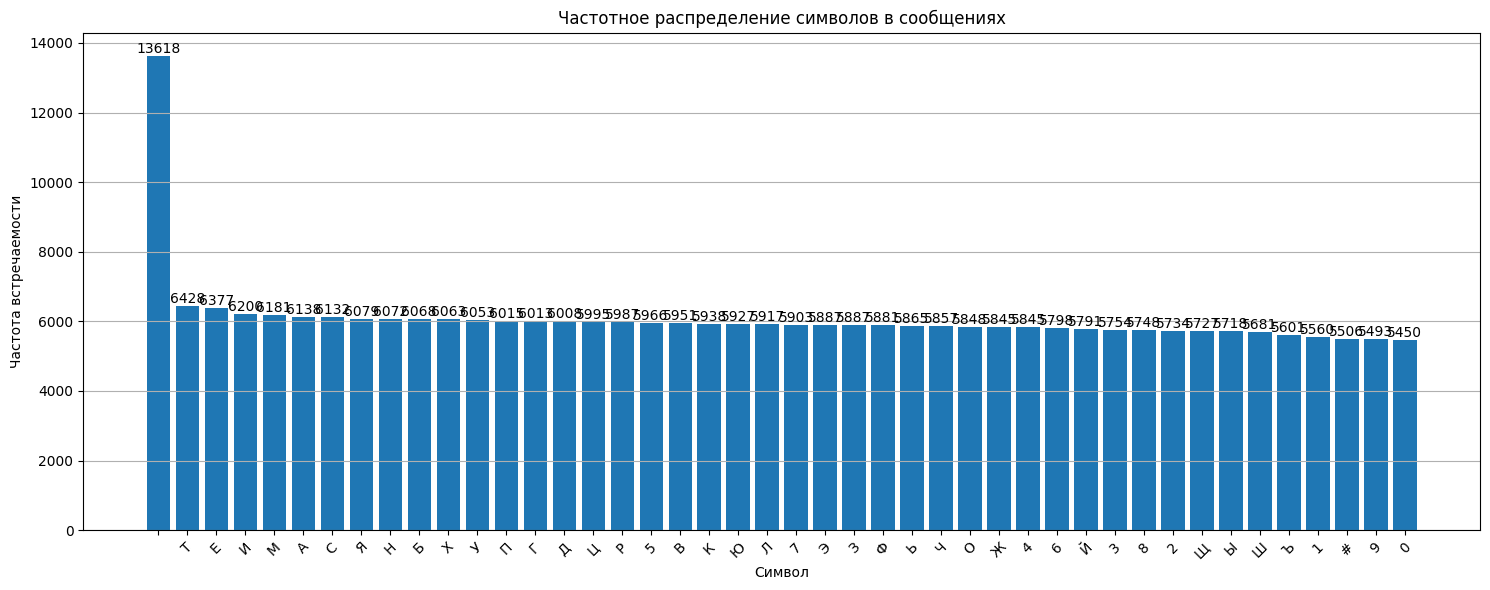

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Загрузка данных
train_df = pd.read_csv('/kaggle/input/decoder/train.csv')

# Анализ длины сообщений
message_lengths = train_df['message'].str.len()
print(f"Минимальная длина сообщения: {message_lengths.min()}")
print(f"Максимальная длина сообщения: {message_lengths.max()}")

# Анализ частоты символов
all_chars = ''.join(train_df['message'].tolist())
char_freq = Counter(all_chars)

# Сортировка символов по частоте
sorted_chars = sorted(char_freq.items(), key=lambda x: x[1], reverse=True)
chars, counts = zip(*sorted_chars)

# Визуализация гистограммы
plt.figure(figsize=(15, 6))
bars = plt.bar(chars, counts)
plt.title('Частотное распределение символов в сообщениях')
plt.xlabel('Символ')
plt.ylabel('Частота встречаемости')

# Добавление подписей с частотами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Несмотря на то, что я получил некоторые знания о данных, на деле оказалось, что подобранные мной во время экспериментов значения сработали лучше. Но очень пригодились знания того, что длины сообщения от 4 до 14 символов и что данные несбалансированные. Благодаря этому я добавил балансировку весами, используя частоты. а также старался использовать более простые модели, т.к. размер последовательностей небольшой и без семантики.

## **Подготовка данных перед подачей в модель.**

Эта ячейка не совсем то, с чего я начинал, точнее, она была куда скромнее в начале, но со временем разрасталась.
Расскажу в принципе, как шел ход моих мыслей. Сначала я пытался руками предобработать данные, насколько я знаю, многим удалось сделать качественную предобработку, благодаря которой они вошли в топ, но спустя какое-то время меня одолело желание попробовать автоматизировать эту задачу. Я знал, что опыта в аудио задачах у меня не было до этого тестового, поэтому я начал двигаться в следующем направлении: а как мне изменить архитектуру так, чтобы она сама научилась делать из шумной спектрограммы хорошую и чистую, но об этом чуть позже. Я бы советовал вернуться к этой клетке и читать комментарии к конфигу после прочтения архитектурного решения, так будет понятнее.

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, random_split
from pathlib import Path
from sklearn.model_selection import KFold
from typing import List, Tuple
from collections import defaultdict
import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Конфигурация
CONFIG = {
    "sample_rate": 8000, # частота дискретизации (по условию была такой)
    "n_mels": 128, # количество mel-банок. Подобрал 128 экспериментально, в решении, которое у меня на kaggle, использовалось именно 128.
                   # Хотя должен отметить, что мое последнее решение, которое показывает немного лучше результат на private показывает,
                   # использует 32 банки. Но разница в одну сотую, поэтому некритично, но решил, что умолчивать об этом не стоит.
    "n_fft": 1024, # длина fft окна, подбирал также экспериментально, и аналогично банкам, 256, скорее всего, более оптимальный выбор, 1024 слишком большое.
    "hop_length": 128, # количество выборок между последовательными кадрами, тут 128 реально работает лучше всего, пробовал и 64, и 32, и 256.
    "max_length": 100, # экспериментально было 100, хотя, аналогично, опираясь на audio_analyze, лучше тут ставить 640,
                       # т.к. 8 секунд - реальная длительность всех аудиофайлов, кроме последних 17 в тесте (с шифром).
    "fmin": 400, # наверное, один из самых главных параметров, с помощью этих порогов качество также сильно зависит.
    "fmax": 1300, # Диапазон выбран наполовину экспериментально, наполовину исходя из той логики, что, как правило,
                  # тональность кода Морзе находится в пределах 600-800 кГЦ. Экспериментально тут то, что я в анализе выше вычислил главную частоту сигнала, которая как раз составила диапазон 400-1300.
                  # Однако я тестировал уже диапазоны и шире, но было хуже.
    "batch_size": 32, # выбирался исходя из памяти GPU на kaggle, было б больше, ставил бы и 64 или 128.
    "hidden_size": 128, # размер скрытых слоев в LSTM.
    "num_classes": 45, # количество классов для классификации
    "mel_dir": "/kaggle/working/precomputed_mels", # путь к mel-спектрограммам трейна
    "train_csv": "/kaggle/input/decoder/train.csv", # путь к трейну
    "audio_dir": "/kaggle/input/decoder/morse_dataset/morse_dataset", # путь до всех аудиофайлов
    "test_csv": "/kaggle/input/decoder/test.csv", # путь к тесту
    "test_mel_dir": "/kaggle/working/precomputed_test_mels", # путь к тестовым mel-спектрограммам
}

# Мапы для символов
CHARACTER_MAPPING = {
    'А': 0, 'Б': 1, 'В': 2, 'Г': 3, 'Д': 4, 'Е': 5, 'Ж': 6, 'З': 7,
    'И': 8, 'Й': 9, 'К': 10, 'Л': 11, 'М': 12, 'Н': 13, 'О': 14,
    'П': 15, 'Р': 16, 'С': 17, 'Т': 18, 'У': 19, 'Ф': 20, 'Х': 21,
    'Ц': 22, 'Ч': 23, 'Ш': 24, 'Щ': 25, 'Ъ': 26, 'Ы': 27, 'Ь': 28,
    'Э': 29, 'Ю': 30, 'Я': 31, ' ': 32, '0': 33, '1': 34, '2': 35,
    '3': 36, '4': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42,
    '#': 43, '<blank>': 44
}
INDEX_MAPPING = {v: k for k, v in CHARACTER_MAPPING.items()}

### **Создание mel-спектрограмм**

Ниже код, который создает mel-спектрограммы и нормализует для подавления влияния шумов. Параметры для mel-спектрограмм смотрите в комментариях к конфигу в коде. \
Все mel-спектрограммы рассчитываются заранее, так получается в разы эффективнее, чем делать это на ходу.

In [ ]:
def precompute_mels(csv_path, audio_dir, save_dir):
    """
    Предварительно вычисляет и сохраняет мел-спектрограммы для аудиофайлов.

    Параметры:
        csv_path (str): Путь к CSV файлу с метаданными (содержит колонку 'id' с именами файлов)
        audio_dir (str/Path): Директория с исходными аудиофайлами
        save_dir (str/Path): Директория для сохранения вычисленных спектрограмм

    Действия:
        1. Загружает аудиофайлы с заданной частотой дискретизации
        2. Вычисляет мел-спектрограммы с параметрами из CONFIG
        3. Нормализует спектрограммы (стандартизация)
        4. Сохраняет спектрограммы как тензоры PyTorch (.pt файлы)

    Примечания:
        - Использует логарифмическую шкалу децибел (power_to_db)
        - Добавляет размерность канала (unsqueeze(0)) для совместимости с CNN
    """
    start_time = time.time()
    df = pd.read_csv(csv_path)
    audio_dir = Path(audio_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    for idx, row in df.iterrows():
        audio_path = audio_dir / row['id']
        # Загрузка аудио с единой частотой дискретизации
        y, sr = librosa.load(str(audio_path), sr=CONFIG["sample_rate"])

        # Вычисление мел-спектрограммы
        mel = librosa.feature.melspectrogram(
            y=y, sr=sr,
            n_mels=CONFIG["n_mels"],     # Количество мел-полос
            n_fft=CONFIG["n_fft"],       # Размер FFT окна
            hop_length=CONFIG["hop_length"], # Шаг между окнами
            fmin=CONFIG["fmin"],         # Минимальная частота
            fmax=CONFIG["fmax"]          # Максимальная частота
        )
        # Преобразование в dB и нормализация
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-8)  # Стандартизация

        # Сохранение тензора [1, n_mels, time]
        torch.save(torch.FloatTensor(mel_db).unsqueeze(0), save_dir / f"{row['id']}.pt")

    duration = time.time() - start_time
    log_timing(f"Precompute mels ({csv_path})", duration)

def precompute_train_mels():
    """
    Предварительно вычисляет mel-спектрограммы для обучающих данных.

    Использует пути из CONFIG:
        - train_csv: Путь к CSV с обучающими данными
        - audio_dir: Директория с аудиофайлами
        - mel_dir: Директория для сохранения спектрограмм
    """
    precompute_mels(
        CONFIG["train_csv"],
        CONFIG["audio_dir"],
        Path(CONFIG["mel_dir"])
    )

def precompute_test_mels():
    """
    Предварительно вычисляет mel-спектрограммы для тестовых данных.

    Использует пути из CONFIG:
        - test_csv: Путь к CSV с тестовыми данными
        - audio_dir: Директория с аудиофайлами
        - test_mel_dir: Директория для сохранения спектрограмм
    """
    precompute_mels(
        CONFIG["test_csv"],
        CONFIG["audio_dir"],
        Path(CONFIG["test_mel_dir"])
    )

### **Аугментации**

Изначально было без аугментаций, но я все же решил добавить их, что действительно слегка помогло. Думаю, что тут есть много пространства для улучшения качества, скорее всего, если придумать качественные дополнительные аугментации можно получить прорыв в скоре. \
Тут я использую же по сути добавление шума, смещение во времени, частотную и временную маскирования, растяжение во времени.

In [ ]:
class AudioAugmenter:
    """
    Класс для аугментации аудио спектрограмм с целью увеличения разнообразия обучающих данных.
    Применяет пять типов преобразований с вероятностью 50% каждое.
    """

    def __init__(self, noise_factor_range=(0.0, 0.001), time_shift_max=200,
                 freq_mask_param=3, time_mask_param=5, time_stretch_range=(0.95, 1.05)):
        """
        Инициализация с параметрами аугментаций:

        :param noise_factor_range: Диапазон коэффициента шума (относительная амплитуда)
        :param time_shift_max: Максимальный сдвиг по времени (в отсчетах)
        :param freq_mask_param: Параметр маскирования частот (количество маскируемых полос)
        :param time_mask_param: Параметр маскирования времени (длительность маски в отсчетах)
        :param time_stretch_range: Диапазон растяжения/сжатия времени
        """
        self.noise_factor_range = noise_factor_range
        self.time_shift_max = time_shift_max
        self.freq_mask = T.FrequencyMasking(freq_mask_param=freq_mask_param)  # Маскирование частот
        self.time_mask = T.TimeMasking(time_mask_param=time_mask_param)  # Маскирование времени
        self.time_stretch_range = time_stretch_range

    def __call__(self, mel):
        """
        Применяет аугментации к входной мел-спектрограмме.

        :param mel: Входная мел-спектрограмма [1, n_mels, time]
        :return: Аугментированная mel-спектрограмма
        """
        # 1. Добавление гауссова шума (с вероятностью 50%)
        if random.random() < 0.5:
            noise_factor = random.uniform(*self.noise_factor_range)
            if noise_factor > 0:
                noise = torch.randn_like(mel) * noise_factor
                mel = mel + noise  # Добавляем шум с малым коэффициентом

        # 2. Сдвиг по времени (с вероятностью 50%)
        if random.random() < 0.5:
            shift = random.randint(-self.time_shift_max, self.time_shift_max)
            mel = torch.roll(mel, shifts=shift, dims=2)  # Циклический сдвиг вдоль временной оси

        # 3. Маскирование частотных полос (с вероятностью 50%)
        if random.random() < 0.5:
            mel = self.freq_mask(mel)  # Случайное обнуление частотных полос

        # 4. Маскирование временных отрезков (с вероятностью 50%)
        if random.random() < 0.5:
            mel = self.time_mask(mel)  # Случайное обнуление временных отрезков

        # 5. Изменение временного масштаба (с вероятностью 50%)
        if random.random() < 0.5:
            stretch_factor = random.uniform(*self.time_stretch_range)
            mel = self._time_stretch(mel, stretch_factor)  # Плавное растяжение/сжатие

        # Ограничение значений для стабильности обучения
        mel = mel.clamp(min=-10, max=10)
        return mel

    def _time_stretch(self, mel, stretch_factor):
        """
        Внутренний метод для изменения временного масштаба спектрограммы.

        :param mel: Входная спектрограмма
        :param stretch_factor: Коэффициент растяжения (1.0 - без изменений)
        :return: Преобразованная mel-спектрограмма
        """
        orig_time = mel.size(2)
        new_time = int(orig_time * stretch_factor)

        # Проверка на допустимый размер
        if new_time <= 0:
            return mel

        # Добавление размерности батча для интерполяции
        mel = mel.unsqueeze(0)

        # Билинейная интерполяция для плавного изменения
        mel = torch.nn.functional.interpolate(
            mel,
            size=(mel.size(2), new_time),
            mode='bilinear',
            align_corners=False
        )
        mel = mel.squeeze(0)

        # Корректировка размеров:
        if new_time < orig_time:
            # Дополнение нулями если стало короче
            pad = torch.zeros(*mel.shape[:-1], orig_time).to(mel.device)
            pad[..., :new_time] = mel
            mel = pad
        elif new_time > orig_time:
            # Обрезка если стало длиннее
            mel = mel[..., :orig_time]

        return mel

### **Датасеты**

Датасеты, для обучения и инференса. На вход я подаю mel-спектрограммы, аугментируя их только на трейне. Так как количество символов несбалансированно, то я применяю весовую балансировку, основанную на их частотах.

In [ ]:
class MorseDataset(Dataset):
    """
    Кастомный Dataset для загрузки и обработки аудиоданных азбуки Морзе.
    Поддерживает аугментацию, фильтрацию невалидных примеров и взвешенную выборку.
    """

    def __init__(self, csv_path: str, is_test=False, subset_size=None, is_train=False):
        """
        Инициализация датасета.

        :param csv_path: Путь к CSV файлу с данными
        :param is_test: Флаг тестового режима (без меток)
        :param subset_size: Ограничение размера датасета (для отладки)
        :param is_train: Флаг обучения (включает аугментации)
        """
        self.is_train = is_train
        self.augmenter = AudioAugmenter() if is_train else None  # Аугментатор только для обучения
        self.df = pd.read_csv(csv_path)

        # Выбор директории с предвычисленными спектрограммами
        self.mel_dir = Path(CONFIG["test_mel_dir"] if is_test else CONFIG["mel_dir"])
        self.valid_indices = []  # Индексы валидных примеров

        # Фильтрация невалидных примеров
        for idx in range(len(self.df)):
            row = self.df.iloc[idx]
            mel_path = self.mel_dir / f"{row['id']}.pt"

            # Пропуск если нет файла спектрограммы
            if not mel_path.exists():
                continue

            mel = torch.load(mel_path, weights_only=True)

            # Применение аугментаций для обучающих данных
            if self.augmenter:
                mel = self.augmenter(mel)

            # Проверка соответствия длины аудио и текста
            input_length = mel.shape[2]
            text = row['message']
            target = [CHARACTER_MAPPING[c] for c in text if c in CHARACTER_MAPPING]
            target_length = len(target)
            ctc_input_length = input_length // 4  # Учет сжатия в модели

            if target_length > ctc_input_length:
                print(f"Пропуск {row['id']}: текст длиннее аудио ({target_length} > {ctc_input_length})")
                continue

            self.valid_indices.append(idx)

        # Ограничение размера датасета (для отладки)
        if subset_size and subset_size > 0:
            self.valid_indices = self.valid_indices[:subset_size]

        self.df = self.df.iloc[self.valid_indices].reset_index(drop=True)

        # Расчет весов классов для балансировки
        all_targets = []
        for idx in range(len(self.df)):
            text = self.df.iloc[idx]['message']
            target = [CHARACTER_MAPPING[c] for c in text if c in CHARACTER_MAPPING]
            all_targets.extend(target)

        # Частоты символов для взвешивания
        unique, counts = np.unique(all_targets, return_counts=True)
        freq_dict = dict(zip(unique, counts))
        total = sum(counts)
        self.class_weights = {cls: total/(count + 1e-8) for cls, count in freq_dict.items()}

        # Веса примеров (средний вес символов в сообщении)
        self.sample_weights = []
        for idx in range(len(self.df)):
            text = self.df.iloc[idx]['message']
            target = [CHARACTER_MAPPING[c] for c in text if c in CHARACTER_MAPPING]
            weight = sum([self.class_weights.get(cls, 1.0) for cls in target])/len(target) if target else 1.0
            self.sample_weights.append(weight)

    def __len__(self):
        """Возвращает количество валидных примеров."""
        return len(self.df)

    def __getitem__(self, idx):
        """
        Возвращает один пример данных.

        :return: tuple (mel_spectrogram, target_sequence, input_length, target_length)
        """
        row = self.df.iloc[idx]
        mel = torch.load(self.mel_dir / f"{row['id']}.pt", weights_only=True)
        text = row['message']
        target = [CHARACTER_MAPPING[c] for c in text if c in CHARACTER_MAPPING]
        input_length = mel.shape[2]  # Временная длина спектрограммы
        return mel, torch.IntTensor(target), input_length, len(target)


class TestMorseDataset(Dataset):
    """
    Упрощенный Dataset для тестовых данных (без меток).
    """

    def __init__(self, csv_path: str):
        """
        :param csv_path: Путь к CSV с тестовыми данными
        """
        self.df = pd.read_csv(csv_path)
        self.mel_dir = Path(CONFIG["test_mel_dir"])  # Директория с тестовыми спектрограммами

    def __len__(self):
        """Количество тестовых примеров."""
        return len(self.df)

    def __getitem__(self, idx):
        """
        Возвращает тестовый пример.

        :return: tuple (mel_spectrogram, input_length, filename)
        """
        row = self.df.iloc[idx]
        filename = row['id']
        mel_path = self.mel_dir / f"{filename}.pt"
        mel = torch.load(mel_path, weights_only=True)
        input_length = mel.shape[2]  # Временная длина
        return mel, input_length, filename

# **Модель и ее архитектура.**

## **Лосс и ранняя остановка.**
Лосс - комбинация CTC loss-а и MSE. Далее при объяснении архитектуры я поясню свой выбор. \
Ранняя остановка тут самая стандартная.

In [ ]:
class EarlyStopping:
    """
    Реализация ранней остановки для прекращения обучения, когда валидационная метрика перестает улучшаться.
    """

    def __init__(self, patience=5, delta=0):
        """
        :param patience: Количество эпох без улучшения перед остановкой
        :param delta: Минимальное требуемое улучшение для сброса счетчика
        """
        self.patience = patience  # Терпение (количество эпох без улучшения)
        self.delta = delta        # Порог значимого улучшения
        self.counter = 0          # Счетчик эпох без улучшения
        self.best_score = None    # Лучшее значение метрики
        self.early_stop = False   # Флаг остановки

    def __call__(self, val_loss):
        """
        Проверяет условие ранней остановки на каждой эпохе.

        :param val_loss: Текущее значение валидационной функции потерь
        """
        score = -val_loss  # Преобразуем loss в score (чем больше - тем лучше)

        if self.best_score is None:
            # Первая итерация - инициализация
            self.best_score = score
        elif score < self.best_score + self.delta:
            # Нет улучшения (с учетом дельты)
            self.counter += 1
            if self.counter >= self.patience:
                # Достигли предела терпения
                self.early_stop = True
        else:
            # Обнаружено улучшение - сбрасываем счетчик
            self.best_score = score
            self.counter = 0


class HybridLoss(nn.Module):
    """
    Комбинированная функция потерь, объединяющая CTC Loss и MSE Loss для предсказания длины последовательности.
    """

    def __init__(self, alpha=0.3):
        """
        :param alpha: Коэффициент для взвешивания вклада MSE Loss
        """
        super().__init__()
        self.ctc_loss = nn.CTCLoss(blank=44)  # CTC Loss с blank token
        self.alpha = alpha  # Весовой коэффициент для MSE

    def forward(self, logits, targets, input_lengths, target_lengths):
        """
        Вычисляет комбинированную функцию потерь.

        :param logits: Выход модели [batch, time, num_classes]
        :param targets: Целевые последовательности [total_target_length]
        :param input_lengths: Длины входных последовательностей [batch]
        :param target_lengths: Длины целевых последовательностей [batch]
        :return: Комбинированное значение потерь
        """
        # 1. CTC Loss (Connectionist Temporal Classification)
        log_probs = torch.nn.functional.log_softmax(logits, dim=2)  # Логарифмы вероятностей
        log_probs = log_probs.permute(1, 0, 2)  # CTC требует [time, batch, num_classes]

        # Учет сжатия временной оси в модели (//4) и защита от нуля
        ctc_loss = self.ctc_loss(
            log_probs,
            targets,
            (input_lengths // 4).clamp(min=1),  # Длины после пулингов
            target_lengths  # Длины целевых последовательностей
        )

        # 2. Length Prediction Loss (MSE)
        # Предсказание длины как количество не-blank токенов
        pred_lengths = torch.sum(torch.argmax(logits, dim=2) != 44, dim=1).float()
        # MSE между предсказанными и истинными длинами
        length_loss = nn.MSELoss()(pred_lengths, target_lengths.float())

        # Комбинированная функция потерь
        return ctc_loss + self.alpha * length_loss

## **Архитектура модели**

Так, ну вот мы и добрались до архитектуры. \
Главная идея в том, чтобы автоматизировать очистку данных. Мой ход мыслей шел примерно следующий: во-первых, у меня не было до этого опыта работы с аудио сигналами, поэтому наилучшую предобработку спектрограмм самостоятельно будет сделать сложно, во-вторых, хочется сэкономить время и сделать как-нибудь так, чтобы сетка сама учила, как преобразовывать плохие данные в хорошие, в-третьих, аугментации и ручная предобработка более точечно работает, человек, кто ее делает, на основе опыта и знаний видит проблемы в данных, поэтому либо улучшает их какими-то фильтрами или другими обработками, либо аугментирует так, чтобы главная модель научилась и на подпорченных данных находить закономерности, в тоже время, если мы обучим сетку, которая будет учить закономерности по улучшению спектрограмм, мы можем надеяться, что она выудит более общие знания о том, как их улучшать (в пределах тренировочной выборки, естественно, но человек может что-то упустить, а модель может это заметить). \
В связи с этим я вспомнил, что во время обучения в DLS мы проходили архитектуры encoder-decoder, тут понял, что я буду делать.
Я сделал простую достаточно encoder-decoder нейронную сеть, ее цель - обучиться улучшать спектрограммы. Она состоит из трех сверточных слоев, первый кодирует, второй "переносит" признаки из кодировщика в декодировщик, углубляя признаки, третий декодирует назад выходную спектрограмму. Специально остановился на небольшом размере, т.к. аудио не такие длинные, сообщения короткие, есть риск переобучиться, если строить слишком глубокие архитектуры. Пробовал 16 и 64, 32 - наиболее оптимальный вариант по скорости и качеству.  \
Далее идет классическая для этой задачи CNN + LSTM нейронная сеть, тут ничего прям примечательного нет, думаю такая нейронка у многих была. Единственное, наверное, это выбор для всех сеток функции активации GELU, т.к. она чуть-чуть лучше подходит для задачи на мой взгляд , чем RELU, так как она обеспечивает высокую стабильность.
\
По поводу лосса. \
Я использовал CTC-loss для основной модели - классика для этого подхода, но мне также надо было как-то обучать SpectrogramEnhancer, потому что CTC-loss не совсем полностью описывает то, что должна делать предобрабатывающая модель, поэтому для улучшения работы этой части кода я добавил лосс, описывающий предсказание длины сообщения, таким образом, я даю дополнительную информацию "улучшателю" mel-спектрограмм, чтобы он лучше обучался.
\
Должен сказать, что я пробовал также использовать другой подход - через темпоральные свертки, однако результаты получались примерно такие же или хуже, поэтому я остановился на том, что попроще и сложнее переобучить.

### **Основная часть: предобрабатывающий encoder-decoder и главная модель - CNN + LSTM**

In [ ]:
class SpectrogramEnhancer(nn.Module):
    """
    Модуль для улучшения mel-спектрограмм перед основной обработкой.
    Применяет последовательность сверточных слоев для выделения полезных признаков.
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # Первый сверточный слой (расширение признакового пространства)
            nn.Conv2d(1, 32, 3, padding=1),  # [B,1,F,T] -> [B,32,F,T]
            nn.GELU(),  # Плавная активация
            nn.BatchNorm2d(32),  # Нормализация по батчу

            # Второй сверточный слой (углубление признаков)
            nn.Conv2d(32, 32, 3, padding=1),  # [B,32,F,T] -> [B,32,F,T]
            nn.GELU(),

            # Финальный сверточный слой (сжатие обратно к 1 каналу)
            nn.Conv2d(32, 1, 3, padding=1)  # [B,32,F,T] -> [B,1,F,T]
        )

    def forward(self, x):
        return self.net(x)


class MorseModel(nn.Module):
    """
    Основная модель для распознавания азбуки Морзе из спектрограмм.
    Сочетает CNN для пространственных признаков и LSTM для временных зависимостей.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Инициализация компонентов
        self.enhancer = SpectrogramEnhancer()  # Предобработка спектрограмм

        # CNN блок для извлечения признаков
        self.cnn = nn.Sequential(
            # Первый сверточный блок
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [B,1,F,T] -> [B,32,F,T]
            nn.BatchNorm2d(32),
            nn.GELU(),  # Gaussian Error Linear Unit
            nn.MaxPool2d(2),  # [B,32,F,T] -> [B,32,F/2,T/2]

            # Второй сверточный блок
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [B,32,F/2,T/2] -> [B,64,F/2,T/2]
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2),  # [B,64,F/2,T/2] -> [B,64,F/4,T/4]

            nn.Dropout(0.2)  # Регуляризация
        )

        # Расчет размеров после CNN
        cnn_output_height = config["n_mels"] // 4  # После двух MaxPool
        self.linear = nn.Linear(64 * cnn_output_height, 512)  # Проецирование в скрытое пространство

        # Рекуррентный блок (BiLSTM)
        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=config["hidden_size"],
            bidirectional=True,  # Двунаправленная LSTM
            num_layers=4,  # Глубокая архитектура
            dropout=0.3,  # Межслойная регуляризация
            batch_first=True  # [B,T,D] формат
        )

        # Нормализация и классификатор
        self.layernorm = nn.LayerNorm(2 * config["hidden_size"])  # Нормализация по фичам
        self.fc = nn.Linear(2 * config["hidden_size"], config["num_classes"])  # Выходной слой

    def forward(self, x, input_lengths):
        # 1. Улучшение спектрограммы
        x = self.enhancer(x)

        # 2. Извлечение признаков CNN
        x = self.cnn(x)

        # 3. Подготовка к LSTM
        B, C, H, T = x.size()
        # Перегруппировка в [B,T,C*H]
        x = x.permute(0, 3, 1, 2).reshape(B, T, C * H)
        x = self.linear(x)  # [B,T,512]

        # 4. Обработка LSTM с упаковкой последовательностей
        packed = nn.utils.rnn.pack_padded_sequence(
            x,
            (input_lengths//4).cpu(),  # Учет сжатия времени
            batch_first=True,
            enforce_sorted=False
        )
        output, _ = self.lstm(packed)
        output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)

        # 5. Нормализация и классификация
        output = self.layernorm(output)
        return self.fc(output)  # [B,T,num_classes]


def collate_fn(batch):
    """
    Функция для объединения примеров в батчи (обучающие данные).
    Обрабатывает:
    - Выравнивание по времени (дополнение нулями)
    - Объединение целей в плоский тензор
    - Сохранение исходных длин
    """
    mels, targets, input_lens, target_lens = zip(*batch)

    # Выравнивание по максимальной длине в батче
    max_time = max(m.shape[2] for m in mels)
    padded_mels = [torch.nn.functional.pad(m, (0, max_time - m.shape[2])) for m in mels]

    # Объединение целей и длин
    targets_flat = torch.cat(targets)
    target_lengths = torch.LongTensor([len(t) for t in targets])

    return (
        torch.stack(padded_mels),  # [B,1,F,T_max]
        targets_flat,  # [sum(target_lens)]
        torch.LongTensor([m.shape[2] for m in mels]),  # [B]
        target_lengths  # [B]
    )


def test_collate_fn(batch):
    """
    Упрощенная функция для тестовых данных (без таргета).
    Только выравнивание по времени и сохранение длин.
    """
    mels, input_lens, ids = zip(*batch)

    # Выравнивание по максимальной длине
    max_time = max(m.shape[2] for m in mels)
    padded_mels = [torch.nn.functional.pad(m, (0, max_time - m.shape[2])) for m in mels]

    return (
        torch.stack(padded_mels),  # [B,1,F,T_max]
        torch.LongTensor(input_lens),  # [B]
        ids  # Список идентификаторов
    )

### **Постобработка выхода модели.**

В результате, то, что выдает главная сеть - это еще не конец, т.к. я не делал end2end подход. Поэтому для начала, чтобы сами выходы CTC-модели обработать, был использовал жадный декодер. \
Жадный декодер был выбран из-за своей скорости и плюс-минус оптимальности, учитывая, что в сообщениях не было смысловой нагрузки. Был вариант с beam_search-ем, но он слишком долго работает. \
После жадкого декодера идет декодирование в реальный русский текст.

In [ ]:
class GreedyDecoder:
    """
    Жадный декодер для преобразования выходных последовательностей модели в текст.
    Обрабатывает выходы CTC-модели, удаляя повторяющиеся и blank-символы.
    """

    def __init__(self):
        # Инициализация blank символа (используется в CTC loss)
        self.blank_id = CHARACTER_MAPPING['<blank>']

    def decode_batch(self, logits_batch: torch.Tensor) -> List[str]:
        """
        Декодирует батч выходных последовательностей модели.

        :param logits_batch: Тензор формы [batch_size, time_steps, num_classes]
        :return: Список декодированных строк для каждого элемента батча
        """
        batch_preds = []
        # Преобразование логитов в вероятности (логарифмические для численной стабильности)
        log_probs = torch.nn.functional.log_softmax(logits_batch, dim=2)
        # Получение наиболее вероятных символов для каждого временного шага
        max_probs, indices = log_probs.max(dim=2)  # Результаты формы [batch_size, time_steps]

        # Обработка каждого элемента батча
        for batch_idx in range(indices.shape[0]):
            sequence = indices[batch_idx].cpu().numpy()  # Переход в numpy для обработки
            sequence = self._collapse_sequence(sequence)  # Удаление повторов и blank
            batch_preds.append(self._convert_to_chars(sequence))  # Преобразование в символы

        return batch_preds

    def _collapse_sequence(self, sequence: np.ndarray) -> List[int]:
        """
        Удаляет повторяющиеся символы и blank-токены из последовательности.

        :param sequence: Входная последовательность индексов
        :return: "Схлопнутая" последовательность без повторов и blanks
        """
        collapsed = []
        prev = None
        for idx in sequence:
            # Сохраняем только неповторяющиеся не-blank символы
            if idx != self.blank_id and idx != prev:
                collapsed.append(idx)
            prev = idx
        return collapsed

    def _convert_to_chars(self, sequence: List[int]) -> str:
        """
        Преобразует последовательность индексов в строку символов.

        :param sequence: Список индексов символов
        :return: Декодированная строка
        """
        return ''.join(
            INDEX_MAPPING.get(idx, '#')  # Заменяем неизвестные символы на #
            for idx in sequence
            if idx in INDEX_MAPPING and INDEX_MAPPING[idx] != '<blank>'  # Игнорируем blank
        )


class MorseDecoder:
    """
    Обертка для декодера с дополнительными функциями преобразования азбуки Морзе.
    Содержит:
    1. Жадный декодер для выходов модели
    2. Словарь для преобразования кодов Морзе в символы
    """

    def __init__(self):
        # Основной жадный декодер
        self.decoder = GreedyDecoder()

        # Словарь для преобразования кодов Морзе в символы
        self.morse_to_char = {
            '.-': 'А', '-...': 'Б', '.--': 'В', '--.': 'Г', '-..': 'Д',
            '.': 'Е', '...-': 'Ж', '--..': 'З', '..': 'И', '.---': 'Й',
            '-.-': 'К', '.-..': 'Л', '--': 'М', '-.': 'Н', '---': 'О',
            '.--.': 'П', '.-.': 'Р', '...': 'С', '-': 'Т', '..-': 'У',
            '..-.': 'Ф', '....': 'Х', '-.-.': 'Ц', '---.': 'Ч', '----': 'Ш',
            '--.-': 'Щ', '--.--': 'Ъ', '-.--': 'Ы', '-..-': 'Ь', '..-..': 'Э',
            '..--': 'Ю', '.-.-': 'Я',
            '-----': '0', '.----': '1', '..---': '2',
            '...--': '3', '....-': '4', '.....': '5', '-....': '6', '--...': '7',
            '---..': '8', '----.': '9',
            '/': ' ',  # Разделитель слов
            '': '#'    # Дефолтный символ для неизвестных кодов
        }

    def decode_batch(self, logits):
        """Интерфейс для декодирования батча (делегирует GreedyDecoder)"""
        return self.decoder.decode_batch(logits)

    def _morse_to_text(self, code: str) -> str:
        """
        Преобразует строку с кодами Морзе в текст (не используется в текущей реализации).

        :param code: Строка с кодами Морзе (например, ".- / -...")
        :return: Декодированный текст (например, "А Б")
        """
        # Разбиваем на слова (разделены '/')
        words = [w.strip() for w in code.split('/') if w.strip()]
        decoded_words = []

        # Декодируем каждое слово
        for word in words:
            # Разбиваем на символы (разделены пробелом)
            chars = word.split(' ')
            # Преобразуем каждый код Морзе в символ
            decoded_word = ''.join(
                self.morse_to_char.get(c.strip(), '#')  # '#' для неизвестных кодов
                for c in chars
                if c.strip()  # Игнорируем пустые коды
            )
            decoded_words.append(decoded_word)

        # Собираем слова в строку с пробелами
        return ' '.join(decoded_words)

# **Обучение модели.**

Тут было много экспериментов, 50 эпох на деле никогда не училось, т.к. срабатывал EarlyStopping. Обычно для оптимального качество достаточно около 30 эпох. Как правило, после 30 эпохи улучшения незначительные или их вовсе нет. Weight_decay ставил для регуляризации, так как сильно переживал из-за переобучения. Должен отметить, что я долго думал, что моя модель переобучается, т.к. на лидерборде отличие от локальных тестов было на 0,1 примерно, но на самом деле - это результат того, что я не справился с задачей со звездочкой. Так как я не раскодировал это сообщение вовремя, в этих аудиофайлах моя модель естественно "ошибалась", хотя на самом деле работала она на них корректно и, как результат, она не переобучена. Все параметры, что ниже написаны, по сути подобраны. Изначально хотел, конечно, использовать optuna, но т.к. работал в kaggle, не было возможности так долго ждать.


In [ ]:
def train_model(model_cls, train_dataset, val_dataset, epochs=50):
    """
    Функция для обучения модели распознавания азбуки Морзе.

    Параметры:
        model_cls: Класс модели для инициализации
        train_dataset: Датасет для обучения
        val_dataset: Датасет для валидации
        epochs: Количество эпох обучения
    """

    # Инициализация инструментов обучения
    scaler = torch.amp.GradScaler('cuda')  # Для mixed precision обучения
    criterion = HybridLoss(alpha=0.2)  # Комбинированная функция потерь

    # Создание взвешенного сэмплера для балансировки классов
    train_weights = [train_dataset.dataset.sample_weights[i] for i in train_dataset.indices]
    sampler = WeightedRandomSampler(
        train_weights,
        len(train_weights),
        replacement=True  # Разрешаем повторение примеров
    )

    # Подготовка DataLoader'ов
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG["batch_size"],
        collate_fn=collate_fn,  # Функция для формирования батчей
        sampler=sampler,  # Используем балансировку классов
        num_workers=4,  # Параллельная загрузка данных
        pin_memory=True  # Быстрый перенос на GPU
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG["batch_size"],
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=True
    )

    # Инициализация модели и оптимизатора
    model = model_cls(CONFIG).to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=3e-4,  # Скорость обучения
        weight_decay=1e-3  # L2 регуляризация
    )

    early_stopping = EarlyStopping(patience=5, delta=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',  # Минимизируем метрику
        factor=0.5,  # Коэффициент уменьшения LR
        patience=3,  # Количество эпох без улучшения
        verbose=True  # Вывод сообщений
    )

    decoder = MorseDecoder()  # Для декодирования предсказаний
    best_lev = float('inf')  # Лучшее значение метрики

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        total_loss = 0.0

        # Фаза обучения
        train_start_time = time.time()
        for batch in train_loader:
            mels, targets_flat, input_lens, target_lengths = batch

            # Перенос данных на устройство (GPU)
            mels = mels.to(device)
            targets_flat = targets_flat.to(device)
            input_lens = input_lens.to(device)
            target_lengths = target_lengths.to(device)

            optimizer.zero_grad()

            # Mixed precision контекст
            with torch.amp.autocast('cuda'):
                logits = model(mels, input_lens)

                # Проверка соответствия длин
                ctc_input_lengths = (input_lens // 4).clamp(min=1)
                assert (target_lengths <= ctc_input_lengths).all(), \
                    f"Invalid lengths: targets {target_lengths.max().item()} vs ctc {ctc_input_lengths.max().item()}"

                # Вычисление потерь
                loss = criterion(logits, targets_flat, input_lens, target_lengths)

            # Обратное распространение с масштабированием градиентов
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # Обрезка градиентов
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        train_duration = time.time() - train_start_time

        # Фаза валидации
        model.eval()
        total_lev = 0
        val_start_time = time.time()
        all_preds = []
        all_truths = []

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                mels, targets_flat, input_lens, target_lengths = batch
                mels = mels.to(device)

                # Получение предсказаний
                logits = model(mels, input_lens)
                preds = decoder.decode_batch(logits)

                # Декодирование истинных значений
                split_targets = torch.split(targets_flat, target_lengths.tolist())
                truths = [decode_target(t) for t in split_targets]

                # Сохранение для анализа
                all_preds.extend(preds)
                all_truths.extend(truths)

                # Периодический вывод примеров
                if batch_idx == 0 and epoch % 2 == 0:
                    print("\nSample Predictions vs Truths:")
                    for p, t in zip(preds[:3], truths[:3]):
                        print(f"Pred: {p} | Truth: {t}")

                # Вычисление расстояния Левенштейна
                total_lev += sum(levenshtein_distance(p, t) for p, t in zip(preds, truths))

        val_duration = time.time() - val_start_time
        avg_lev = total_lev / len(val_dataset)  # Среднее расстояние по датасету

        # Обновление параметров обучения
        epoch_loss = total_loss / len(train_loader)
        scheduler.step(avg_lev)  # Адаптация LR
        early_stopping(avg_lev)  # Проверка ранней остановки

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        # Логирование и сохранение модели
        epoch_duration = time.time() - epoch_start_time
        log_timing(f"Epoch {epoch+1} Training", train_duration)
        log_timing(f"Epoch {epoch+1} Validation", val_duration)
        log_timing(f"Epoch {epoch+1} Total", epoch_duration)

        print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Lev: {avg_lev:.2f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        if avg_lev < best_lev:
            best_lev = avg_lev
            torch.save(model.state_dict(), "best_model.pth")  # Сохранение лучшей модели

    return model

## Вспомогательные функции: логирование времени, декодирование таргета, вычисление расстояния Левенштейна.

In [ ]:
# Инициализация лога времени выполнения
timing_log = []

def log_timing(event, duration):
    """
    Логирует время выполнения события и выводит его в консоль.

    :param event: Название события (строка)
    :param duration: Длительность выполнения в секундах (float)
    """
    timing_log.append(f"{event}: {duration:.2f} секунд")
    print(f"{event}: {duration:.2f} секунд")

def decode_target(target):
    """
    Преобразует тензор с индексами символов в читаемую строку.

    :param target: Тензор с индексами символов (torch.Tensor)
    :return: Декодированная строка (пропускает blank token 44)
    """
    return ''.join([INDEX_MAPPING.get(idx.item(), '?') for idx in target if idx != 44])

def levenshtein_distance(s1: str, s2: str) -> int:
    """
    Вычисляет расстояние Левенштейна между двумя строками (минимальное количество
    операций вставки, удаления или замены для превращения s1 в s2).

    :param s1: Первая строка
    :param s2: Вторая строка
    :return: Целочисленное расстояние Левенштейна

    Особенности реализации:
    - Использует динамическое программирование с оптимизацией памяти (O(n) памяти)
    - Всегда вычисляет расстояние от более короткой строки к более длинной
    - Сложность O(n*m), где n и m - длины строк
    """
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)  # Всегда s1 >= s2

    if len(s2) == 0:
        return len(s1)  # Если s2 пустая - нужно удалить все символы s1

    # Инициализация предыдущей строки матрицы [0..len(s2)]
    previous_row = range(len(s2) + 1)

    for i, c1 in enumerate(s1):
        current_row = [i + 1]  # Первый элемент = i+1 (удаление)

        for j, c2 in enumerate(s2):
            # Вычисление стоимости операций:
            insertions = previous_row[j + 1] + 1  # Вставка
            deletions = current_row[j] + 1        # Удаление
            substitutions = previous_row[j] + (c1 != c2)  # Замена (0 если символы совпадают)

            current_row.append(min(insertions, deletions, substitutions))

        previous_row = current_row  # Переходим к следующей строке матрицы

    return previous_row[-1]  # Последний элемент содержит итоговое расстояние

# **Генерация сабмита.**

In [ ]:
def generate_single_submission(model_path, test_csv, output_file="submission.csv"):
    """
    Генерирует файл с предсказаниями для тестовых данных с использованием одной обученной модели.

    Параметры:
        model_path (str): Путь к файлу с сохраненными весами модели
        test_csv (str): Путь к CSV-файлу с тестовыми данными
        output_file (str): Имя файла для сохранения предсказаний (по умолчанию "submission.csv")

    Возвращает:
        None (сохраняет предсказания в CSV-файл)
    """

    # 1. Подготовка тестовых данных
    test_dataset = TestMorseDataset(test_csv)  # Инициализация тестового датасета
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG["batch_size"],  # Используем batch_size из конфига
        collate_fn=test_collate_fn,  # Функция для формирования тестовых батчей
        num_workers=4  # Параллельная загрузка данных
    )

    # 2. Инициализация модели и декодера
    decoder = MorseDecoder()  # Декодер для преобразования выхода модели в текст
    model = MorseModel(CONFIG).to(device)  # Создание модели с параметрами из конфига

    # 3. Загрузка весов модели
    # С явным указанием устройства и проверкой весов (weights_only=True для безопасности)
    model.load_state_dict(
        torch.load(model_path, map_location=device, weights_only=True)
    )
    model.eval()  # Переводим модель в режим оценки

    # 4. Подготовка для сохранения результатов
    all_preds = []  # Список для хранения предсказаний
    all_ids = []    # Список для хранения идентификаторов аудиофайлов

    # 5. Генерация предсказаний
    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch in test_loader:
            padded_mels, input_lens, ids = batch  # Распаковка батча

            # Перенос данных на нужное устройство (GPU/CPU)
            padded_mels = padded_mels.to(device)

            # Прямой проход через модель
            logits = model(padded_mels, input_lens.to(device))

            # Декодирование выхода модели в текст
            preds = decoder.decode_batch(logits)

            # Сохранение результатов
            all_preds.extend(preds)
            all_ids.extend(ids)

    # 6. Сохранение результатов в CSV-файл
    df = pd.DataFrame({
        "id": all_ids,  # Идентификаторы файлов
        "message": all_preds  # Предсказанные сообщения
    })

    df.to_csv(output_file, index=False)  # Сохраняем без индексов
    print(f"Предсказания сохранены в файл: {output_file}")

# **Запуск решения.**

In [ ]:
if __name__ == "__main__":
    """
    Главный блок выполнения скрипта для обучения модели и генерации предсказаний.
    Последовательность операций:
    1. Подготовка директорий
    2. Предварительное вычисление спектрограмм
    3. Разделение данных на обучающую и валидационную выборки
    4. Обучение модели
    5. Генерация предсказаний на тестовых данных
    6. Сохранение логов времени выполнения
    """

    total_start_time = time.time()  # Засекаем общее время выполнения

    # 1. Подготовка директорий для спектрограмм
    Path(CONFIG["mel_dir"]).mkdir(parents=True, exist_ok=True)  # Для обучающих данных
    Path(CONFIG["test_mel_dir"]).mkdir(parents=True, exist_ok=True)  # Для тестовых данных

    # 2. Предварительное вычисление мел-спектрограмм (если еще не вычислены)
    if not list(Path(CONFIG["mel_dir"]).glob("*.pt")):
        print("Вычисление мел-спектрограмм для ОБУЧАЮЩИХ данных...")
        precompute_train_mels()  # Вычисляем и сохраняем спектрограммы

    if not list(Path(CONFIG["test_mel_dir"]).glob("*.pt")):
        print("Вычисление мел-спектрограмм для ТЕСТОВЫХ данных...")
        precompute_test_mels()

    # 3. Подготовка и разделение данных
    full_dataset = MorseDataset(CONFIG["train_csv"])  # Загрузка полного датасета

    # Разделение на обучающую и валидационную выборки (80/20)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size

    # Фиксируем random seed для воспроизводимости
    train_dataset, val_dataset = random_split(
        full_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

    # 4. Обучение модели
    train_model(
        model_cls=MorseModel,  # Класс модели для обучения
        train_dataset=train_dataset,  # Данные для обучения
        val_dataset=val_dataset,  # Данные для валидации
        epochs=50  # Количество эпох
    )

    # 5. Генерация предсказаний на тестовых данных
    generate_single_submission(
        model_path="best_model.pth",  # Используем лучшую сохраненную модель
        test_csv=CONFIG["test_csv"],  # Путь к тестовым данным из конфига
        output_file="submission.csv"  # Файл для сохранения результатов
    )

    # 6. Финализация и сохранение логов
    total_duration = time.time() - total_start_time
    log_timing("Общее время выполнения", total_duration)

    # Сохраняем логи времени в файл
    with open("timing_log.txt", "w") as f:
        f.write("\n".join(timing_log))

# **Дополнительно: улучшения текущего решения и общая хронологическая история придумывания решения.**

Про улучшения текущего подхода.
1. У меня были мысли о том, чтобы проводить обучение в два этапа. Сначала обучить encoder-decoder, а на чистых абсолютно mel-спектрограммах обучать главную модель, но для такого подхода надо синтезировать чистые mel-спектрограммы. Я по времени не успевал это реализовать, поэтому оставил одновременное обучение, хотя думаю оптимальнее было бы обучать отдельно.
2. Умеренное усложнение encoder-decoder, возможно, замена на автокодировщик.
3. Добавить более качественную постобработку, возможно, заменить жадный декодер на еще одну модель.

Про хронологический ход моих мыслей.
1.   Изучил специфику и суть проблемы. Погуглил, посмотрел, что обычно в таких задачах хорошо работает.
2.   На основе изученных знаний сделал бейзлайн - простую CNN+LSTM модель - выбил скор 1,7 на лидерборде.
3. Думал, как лучше предобработать данные, добавлял аугментации и балансировку - сильно не помогало.
4. Возникла идея с автоматизацией предобработки.
5. Реализация идеи, дополнения к модели, тестирование на кросс-валидации, добавление ранней остановки. Так как данных довольно много, кросс-валидация на 3-ех, а тем более 5-ти фолдах работала очень долго, поэтому отказался в пользу 80/20 разделения данных на трейн и валидацию.
6. Тщетно пытался улучшить скор подбором гиперпараметров и параметров предобработки - не получалось.
7. Пробовал другую архитектуру с темпоральными свертками - лучше не получалось, только на том же уровне. Остановился на достигнутом.

Вот собственно и конец, это мое решение. \
Спасибо за такую интересную задачу и за прочтение этой работы! \
Хорошего Вам времени суток!